In [1]:
!pip install librosa -U

In [2]:


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave # for reading audio files in .wav format
import pylab # for plotting waveforms and spectrograms
from pathlib import Path
from scipy import signal
from scipy.io import wavfile # wavfile reads wav files and returns the sample rate (in samples/sec) and data as numpy array
from sklearn.metrics import confusion_matrix # for confusion matrix plot
import itertools # itertools is used for efficient looping
from tqdm import tqdm
import librosa #Python package for music & audio files
import librosa.display
import librosa.display as lplt



In [3]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alanchn31/free-spoken-digits")

print("Path to dataset files:", path)

100%|██████████| 15.7M/15.7M [00:01<00:00, 10.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alanchn31/free-spoken-digits/versions/1


In [4]:
# Set paths to input and output data
INPUT_DIR = "/root/.cache/kagglehub/datasets/alanchn31/free-spoken-digits/versions/1/free-spoken-digit-dataset-master"
# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in parent_list:
    print(i)

acquire_data
utils
README.md
__init__.py
recordings
pip_requirements.txt
.gitignore
metadata.py


In [5]:
recordings_path =INPUT_DIR+ "/recordings"
if os.path.exists(recordings_path) and os.path.isdir(recordings_path):
    # List all entries in the directory
    recordings = os.listdir(recordings_path)

    # Optionally, sort the list for consistent ordering
    recordings.sort()

    # Get the first 10 records (or all if less than 10)
    first_10 = recordings[:10]

    print("First 10 files in the recordings directory:")
    for record in first_10:
        print(record)
else:
    print("The recordings directory does not exist at:", recordings_path)

First 10 files in the recordings directory:
0_george_0.wav
0_george_1.wav
0_george_10.wav
0_george_11.wav
0_george_12.wav
0_george_13.wav
0_george_14.wav
0_george_15.wav
0_george_16.wav
0_george_17.wav


## prepareing the dataset

In [6]:
#extract the labels from recordings names
audio_files = [f for f in os.listdir(recordings_path) if f.endswith('.wav')]
labels = [int(f.split('_')[0]) for f in audio_files]

In [7]:
from sklearn.model_selection import train_test_split


# Split the dataset: 70% train, 15% val, 15% test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    audio_files, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [8]:
# Function to extract MFCC features
def extract_mfcc(file_path, sr=None, n_mfcc=13, frame_duration=0.015, hop_duration=0.0075):
    """
    Extract MFCC features from an audio file.

    Parameters:
    - file_path: Path to the audio file.
    - sr: Sampling rate. If None, uses the file's sampling rate.
    - n_mfcc: Number of MFCC coefficients.
    - frame_duration: Duration of each frame in seconds.
    - hop_duration: Hop length between frames in seconds.

    Returns:
    - MFCC features as a numpy array of shape (n_frames, n_mfcc).
    """
    audio, sr = librosa.load(file_path, sr=sr)
    n_fft = int(frame_duration * sr)
    hop_length = int(hop_duration * sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc.T  # Shape: (n_frames, n_mfcc)

# Extract MFCCs for training set
train_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in train_files]

# Extract MFCCs for validation set
val_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in val_files]

# Extract MFCCs for test set
test_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in test_files]

/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [9]:
# Concatenate all training MFCCs to compute normalization statistics
all_train_mfccs = np.vstack(train_mfccs)

# Compute mean and std for each MFCC coefficient
mean_mfcc = np.mean(all_train_mfccs, axis=0)
std_mfcc = np.std(all_train_mfccs, axis=0)

# Function to normalize MFCCs
def normalize_mfcc(mfcc, mean, std):
    return (mfcc - mean) / std

# Normalize MFCCs for all sets
train_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in train_mfccs]
val_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in val_mfccs]
test_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in test_mfccs]

## the classifier

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

def create_mlp_classifier(input_dim, n_classes=10, hidden_units=[128, 64], dropout_rate=0.3):
    """
    Create a Multi-Layer Perceptron (MLP) classifier using TensorFlow/Keras.

    Parameters:
    - input_dim (int): Number of input features (e.g., 13 for mean MFCC vectors).
    - n_classes (int): Number of output classes (default 10 for digits 0-9).
    - hidden_units (list): List of integers specifying the number of units in each hidden layer
                         (default [128, 64] for two hidden layers).
    - dropout_rate (float): Dropout rate for regularization (default 0.3).

    Returns:
    - model: Compiled Keras Sequential model ready for training.
    """
    model = Sequential([
        Input(shape=(input_dim,)),  # Explicit Input layer
    ])

    # Add hidden layers
    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [11]:

# Example usage:
input_dim = train_mfccs_norm[0].shape[1]  # Get the number of MFCCs
model = create_mlp_classifier(input_dim)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,698 (41.79 KB)

 Trainable params: 10,698 (41.79 KB)

 Non-trainable params: 0 (0.00 B)

## Baseline Approach: Compute the Mean MFCC Vector

In [12]:
# Compute mean MFCC vectors for training set
train_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in train_mfccs_norm])
# Shape: (n_train_utterances, n_mfcc)

# Compute mean MFCC vectors for validation set
val_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in val_mfccs_norm])
# Shape: (n_val_utterances, n_mfcc)

# Compute mean MFCC vectors for test set
test_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in test_mfccs_norm])
# Shape: (n_test_utterances, n_mfcc)

print("Train vectors shape:", train_mean_vectors.shape)
print("Train labels shape:", len(train_labels))
print("Validation vectors shape:", val_mean_vectors.shape)
print("Validation labels shape:", len(val_labels))
print("Test vectors shape:", test_mean_vectors.shape)
print("Test labels shape:", len(val_labels))

Train vectors shape: (2100, 13)
Train labels shape: 2100
Validation vectors shape: (450, 13)
Validation labels shape: 450
Test vectors shape: (450, 13)
Test labels shape: 450


In [13]:
# Convert inputs and labels to NumPy arrays explicitly
train_mean_vectors = np.array(train_mean_vectors, dtype=np.float32)
val_mean_vectors = np.array(val_mean_vectors, dtype=np.float32)
test_mean_vectors = np.array(test_mean_vectors, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
val_labels = np.array(val_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

# Verify shapes
print("Train vectors shape:", train_mean_vectors.shape)
print("Train labels shape:", train_labels.shape)
print("Validation vectors shape:", val_mean_vectors.shape)
print("Validation labels shape:", val_labels.shape)
print("Test vectors shape:", test_mean_vectors.shape)
print("Test labels shape:", test_labels.shape)

Train vectors shape: (2100, 13)
Train labels shape: (2100,)
Validation vectors shape: (450, 13)
Validation labels shape: (450,)
Test vectors shape: (450, 13)
Test labels shape: (450,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Create the MLP model
n_mfcc = train_mean_vectors.shape[1]  # e.g., 13
mlp_model_baseline = create_mlp_classifier(input_dim=n_mfcc)


# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history_baseline = mlp_model_baseline.fit(
    train_mean_vectors, train_labels,
    validation_data=(val_mean_vectors, val_labels),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss_baseline, test_accuracy_baseline = mlp_model_baseline.evaluate(test_mean_vectors, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy_baseline:.4f}")
print(f"Test Loss: {test_loss_baseline:.4f}")

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2090 - loss: 2.1821 - val_accuracy: 0.5578 - val_loss: 1.7212
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4664 - loss: 1.6144 - val_accuracy: 0.7111 - val_loss: 1.1166
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 1.1199 - val_accuracy: 0.7711 - val_loss: 0.7905
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6700 - loss: 0.9368 - val_accuracy: 0.8467 - val_loss: 0.6289
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7416 - loss: 0.7570 - val_accuracy: 0.8444 - val_loss: 0.5442
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.6959 - val_accuracy: 0.8689 - val_loss: 0.4848
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.6619 - val_accuracy: 0.8622 - val_loss: 0.4393
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7649 - loss: 0.6213 - val_accuracy: 0.8889 - 

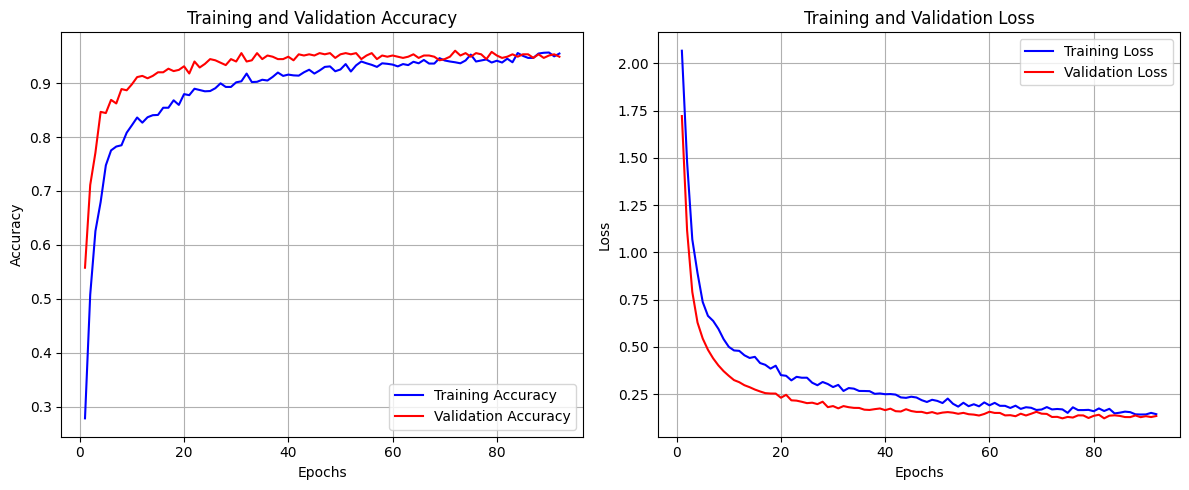

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_baseline is available from the model training
# history_baseline = mlp_model_baseline.fit(...)

# Extract metrics from history
train_loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']
train_accuracy = history_baseline.history['accuracy']
val_accuracy = history_baseline.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

## Approach 1: Concatenation with Padding

In [ ]:
# Step 1: Find the maximum number of frames
max_frames = max(max(mfcc.shape[0] for mfcc in train_mfccs_norm),
                 max(mfcc.shape[0] for mfcc in val_mfccs_norm),
                 max(mfcc.shape[0] for mfcc in test_mfccs_norm))

# Step 2: Pad and flatten MFCCs
def pad_and_flatten_mfccs(mfccs, max_frames, n_mfcc):
    """
    Pad MFCC matrices to max_frames and flatten to a single vector.

    Parameters:
    - mfccs: List of MFCC matrices, each shape (n_frames_i, n_mfcc)
    - max_frames: Maximum number of frames to pad to
    - n_mfcc: Number of MFCC coefficients

    Returns:
    - Flattened array of shape (n_utterances, max_frames * n_mfcc)
    """
    flattened = []
    for mfcc in mfccs:
        # Pad with zeros to (max_frames, n_mfcc)
        pad_width = ((0, max_frames - mfcc.shape[0]), (0, 0))
        padded = np.pad(mfcc, pad_width, mode='constant', constant_values=0)
        # Flatten to 1D vector
        flattened.append(padded.flatten())
    return np.array(flattened, dtype=np.float32)

# Process all sets
train_flattened = pad_and_flatten_mfccs(train_mfccs_norm, max_frames, n_mfcc)
val_flattened = pad_and_flatten_mfccs(val_mfccs_norm, max_frames, n_mfcc)
test_flattened = pad_and_flatten_mfccs(test_mfccs_norm, max_frames, n_mfcc)

# Verify shapes
print("Train flattened shape:", train_flattened.shape)
print("Validation flattened shape:", val_flattened.shape)
print("Test flattened shape:", test_flattened.shape)

Train flattened shape: (2100, 3965)
Validation flattened shape: (450, 3965)
Test flattened shape: (450, 3965)


In [ ]:
# Define the autoencoder function
def create_autoencoder_1(input_dim, encoding_dim=400):
    """
    Create a simpler autoencoder with L2 regularization.
    """
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(encoding_dim, activation='relu', name='encoding'),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(input_dim, activation='linear')
    ])

    encoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(encoding_dim, activation='relu')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Set up bottleneck dimensions to test
bottleneck_dims = [50, 100, 150, 200, 250, 300, 350, 400]
test_accuracies = []
autoencoder_histories = []
classifier_histories = []

# Input dimension
input_dim = max_frames * n_mfcc

# Loop over bottleneck dimensions
for encoding_dim in bottleneck_dims:
    print(f"\nTesting bottleneck dimension: {encoding_dim}")

    # Create and train the autoencoder
    autoencoder_1, encoder_1 = create_autoencoder_1(input_dim, encoding_dim)
    history_AE1 = autoencoder_1.fit(
        train_flattened, train_flattened,
        validation_data=(val_flattened, val_flattened),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
        verbose=0
    )

    # Save the autoencoder and encoder models
    autoencoder_1.save(f'autoencoder_dim_{encoding_dim}.keras')
    encoder_1.save(f'encoder_dim_{encoding_dim}.keras')

    # Store the autoencoder history
    autoencoder_histories.append(history_AE1.history)

    # Generate encoded representations
    train_encoded_1 = encoder_1.predict(train_flattened, verbose=0)
    val_encoded_1 = encoder_1.predict(val_flattened, verbose=0)
    test_encoded_1 = encoder_1.predict(test_flattened, verbose=0)

    # Create and train the MLP classifier
    mlp_model_1 = create_mlp_classifier(input_dim=encoding_dim)
    history_1 = mlp_model_1.fit(
        train_encoded_1, train_labels,
        validation_data=(val_encoded_1, val_labels),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Save the MLP classifier model
    mlp_model_1.save(f'mlp_classifier_dim_{encoding_dim}.keras')

    # Store the classifier history
    classifier_histories.append(history_1.history)

    # Evaluate on test set
    test_loss_1, test_accuracy_1 = mlp_model_1.evaluate(test_encoded_1, test_labels, verbose=0)
    print(f"Approach 1 Test Accuracy for {encoding_dim}D: {test_accuracy_1:.4f}")
    print(f"Approach 1 Test Loss for {encoding_dim}D: {test_loss_1:.4f}")

    # Store the accuracy
    test_accuracies.append(test_accuracy_1)



Testing bottleneck dimension: 50
Approach 1 Test Accuracy for 50D: 0.7378
Approach 1 Test Loss for 50D: 0.7802

Testing bottleneck dimension: 100
Approach 1 Test Accuracy for 100D: 0.8244
Approach 1 Test Loss for 100D: 0.5429

Testing bottleneck dimension: 150
Approach 1 Test Accuracy for 150D: 0.8711
Approach 1 Test Loss for 150D: 0.4252

Testing bottleneck dimension: 200
Approach 1 Test Accuracy for 200D: 0.8933
Approach 1 Test Loss for 200D: 0.3609

Testing bottleneck dimension: 250
Approach 1 Test Accuracy for 250D: 0.8756
Approach 1 Test Loss for 250D: 0.4337

Testing bottleneck dimension: 300
Approach 1 Test Accuracy for 300D: 0.9022
Approach 1 Test Loss for 300D: 0.3412

Testing bottleneck dimension: 350
Approach 1 Test Accuracy for 350D: 0.9200
Approach 1 Test Loss for 350D: 0.2789

Testing bottleneck dimension: 400
Approach 1 Test Accuracy for 400D: 0.9089
Approach 1 Test Loss for 400D: 0.3151


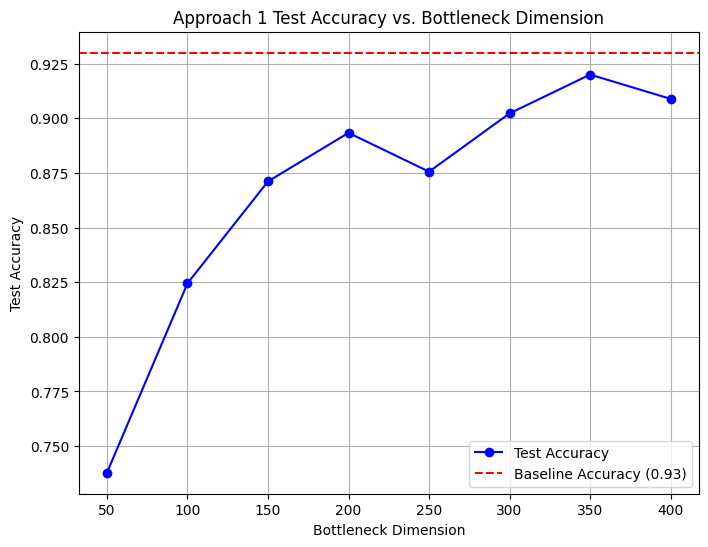


Summary of Test Accuracies:
Bottleneck 50D: 0.7378
Bottleneck 100D: 0.8244
Bottleneck 150D: 0.8711
Bottleneck 200D: 0.8933
Bottleneck 250D: 0.8756
Bottleneck 300D: 0.9022
Bottleneck 350D: 0.9200
Bottleneck 400D: 0.9089


In [ ]:
# Plot the test accuracies vs. bottleneck dimensions
plt.figure(figsize=(8, 6))
plt.plot(bottleneck_dims, test_accuracies, 'b-o', label='Test Accuracy')
plt.axhline(y=0.93, color='r', linestyle='--', label='Baseline Accuracy (0.93)')
plt.title('Approach 1 Test Accuracy vs. Bottleneck Dimension')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Test Accuracy')
plt.xticks(bottleneck_dims)
plt.legend()
plt.grid(True)
plt.savefig('approach1_accuracy_vs_bottleneck.png')
plt.show()

# Print summary
print("\nSummary of Test Accuracies:")
for dim, acc in zip(bottleneck_dims, test_accuracies):
    print(f"Bottleneck {dim}D: {acc:.4f}")

Justification for Choosing a 350D Bottleneck Size in Approach 1
For Approach 1, I concatenated padded MFCC vectors (3900D) and used an autoencoder to compress them into a single vector, classified by the same MLP as the Baseline (accuracy 0.93). To select the bottleneck size, I tested dimensions from 50D to 400D. Based on the results, I chose 350D, which achieved a test accuracy of 0.9200.

Why 350D?

Highest Accuracy: At 0.9200, 350D outperforms all other sizes and is only 0.01 below the Baseline’s 0.93, maximizing classification performance.
Effective Compression: It reduces the 3900D input to ~9.0% of its size, balancing information retention and efficiency.
Robustness: Strong accuracies at 300D (0.9022) and 400D (0.9089) confirm the stability of this range, but 350D’s peak makes it optimal.
Better Than Alternatives: Compared to 400D (0.9089), 350D achieves higher accuracy with fewer dimensions, avoiding potential overfitting.

Conclusion
I selected 350D for Approach 1 because it delivers the highest test accuracy (0.9200) while compressing the 3900D input significantly. Empirical testing across 50D to 400D confirms 350D as the best choice, aligning with the assignment’s goal of generating an effective single-vector representation.


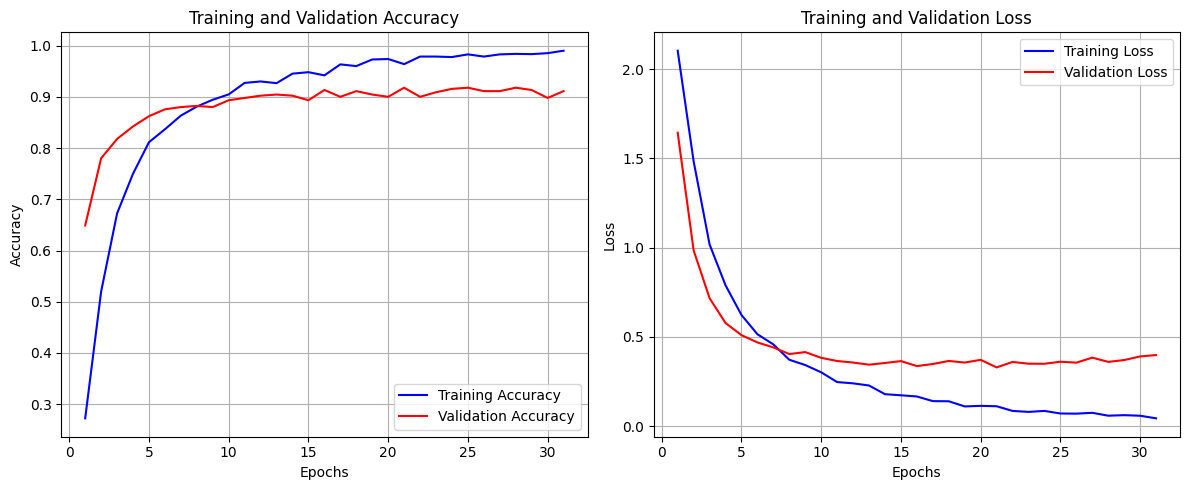

Bottleneck 350D: 0.9200


In [ ]:
import matplotlib.pyplot as plt

train_loss = classifier_histories[6]['loss']
val_loss = classifier_histories[6]['val_loss']
train_accuracy = classifier_histories[6]['accuracy']
val_accuracy = classifier_histories[6]['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

dim = bottleneck_dims[6]
acc = test_accuracies[6]
print(f"Bottleneck {dim}D: {acc:.4f}")

## Approach 2

In [34]:
def get_predictive_triplets(mfccs, set_name=""):
    pairs = []
    targets = []
    for mfcc in mfccs:
        for i in range(len(mfcc) - 2):
            pair = np.concatenate([mfcc[i], mfcc[i + 1]])
            target = mfcc[i + 2]
            pairs.append(pair)
            targets.append(target)
    return np.array(pairs, dtype=np.float32), np.array(targets, dtype=np.float32)


# Prepare pairs
print("Preparing training pairs...")
train_pairs, train_targets = get_predictive_triplets(train_mfccs_norm, "train")
print("Preparing validation pairs...")
val_pairs, val_targets = get_predictive_triplets(val_mfccs_norm, "val")
print("Train pairs shape:", train_pairs.shape)  # Expected: (123520, 26)
print("Train targets shape:", train_targets.shape)  # Expected: (123520, 13)
print("Validation pairs shape:", val_pairs.shape)  # Expected: (26823, 26)
print("Validation targets shape:", val_targets.shape)

Preparing training pairs...
Preparing validation pairs...
Train pairs shape: (119320, 26)
Train targets shape: (119320, 13)
Validation pairs shape: (25923, 26)
Validation targets shape: (25923, 13)


In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam

# ------------------------------------------------------------------------------
# 1) DATA PREP: create (frame_t, frame_{t+1}) → frame_{t+2} triplets
# ------------------------------------------------------------------------------
def get_predictive_triplets(mfccs, set_name=""):
    """
    Input:
      - mfccs: list of arrays, each shape (n_frames, n_mfcc)
    Output:
      - X: array shape (total_pairs, 2*n_mfcc)
      - y: array shape (total_pairs,   n_mfcc)
    """
    pairs = []
    targets = []

    for utt_idx, utt in enumerate(mfccs):
        n_frames = utt.shape[0]
        # For each triple in the utterance
        for i in range(n_frames - 2):
            f_t   = utt[i]
            f_tp1 = utt[i + 1]
            f_tp2 = utt[i + 2]
            pairs.append( np.concatenate([f_t, f_tp1]) )
            targets.append(f_tp2)

    print(f"{set_name}: generated {len(pairs)} predictive triplets")
    X = np.array(pairs, dtype=np.float32)
    y = np.array(targets, dtype=np.float32)
    return X, y

# ------------------------------------------------------------------------------
# 2) HYPERPARAMETERS & DATA LOADING
# ------------------------------------------------------------------------------
n_mfcc = 13                # your feature dimension per frame
input_dim  = n_mfcc * 2    # we concatenate two frames
encoding_dim = 10          # bottleneck size
output_dim = n_mfcc        # predict one frame

# Assume these are already loaded & normalized lists of numpy arrays:
#   train_mfccs_norm, val_mfccs_norm
# each element is shape (n_frames, n_mfcc)

# Create train/val sets
X_train, y_train = get_predictive_triplets(train_mfccs_norm, set_name="TRAIN")
X_val,   y_val   = get_predictive_triplets(val_mfccs_norm,   set_name="VALID")

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ",   X_val.shape,   "y_val:  ",   y_val.shape)

# ------------------------------------------------------------------------------
# 3) MODEL DEFINITION
# ------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_stable_predictor(input_dim, encoding_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(256), LeakyReLU(), BatchNormalization(), Dropout(0.1),
        Dense(128), LeakyReLU(), BatchNormalization(), Dropout(0.1),

        Dense(encoding_dim * 2), LeakyReLU(), BatchNormalization(),
        Dense(encoding_dim, name='bottleneck'), LeakyReLU(), BatchNormalization(),

        Dense(128), LeakyReLU(), BatchNormalization(),
        Dense(256), LeakyReLU(), BatchNormalization(),

        Dense(output_dim, activation='linear'),
    ], name="stable_predictive_autoencoder")

    optimizer = Adam(learning_rate=3e-3, clipnorm=1.0)
    # Huber loss is less sensitive to large errors than MSE
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

# Instantiate
model = create_stable_predictor(input_dim=26, encoding_dim=15, output_dim=13)
model.summary()

# Callbacks
es  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=2
)

model.save('stable_predictive_autoencoder.keras')
print("Saved stable model.")


TRAIN: generated 119320 predictive triplets
VALID: generated 25923 predictive triplets
X_train: (119320, 26) y_train: (119320, 13)
X_val:   (25923, 26) y_val:   (25923, 13)


Model: "stable_predictive_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 30)             │         3,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,808 (335.19 KB)

 Trainable params: 84,182 (328.84 KB)

 Non-trainable params: 1,626 (6.35 KB)

Epoch 1/200
1865/1865 - 23s - 12ms/step - loss: 0.1726 - val_loss: 0.1470 - learning_rate: 0.0030
Epoch 2/200
1865/1865 - 9s - 5ms/step - loss: 0.1544 - val_loss: 0.1400 - learning_rate: 0.0030
Epoch 3/200
1865/1865 - 7s - 4ms/step - loss: 0.1498 - val_loss: 0.1344 - learning_rate: 0.0030
Epoch 4/200
1865/1865 - 10s - 5ms/step - loss: 0.1476 - val_loss: 0.1331 - learning_rate: 0.0030
Epoch 5/200
1865/1865 - 10s - 6ms/step - loss: 0.1461 - val_loss: 0.1328 - learning_rate: 0.0030
Epoch 6/200
1865/1865 - 10s - 5ms/step - loss: 0.1453 - val_loss: 0.1310 - learning_rate: 0.0030
Epoch 7/200
1865/1865 - 8s - 4ms/step - loss: 0.1445 - val_loss: 0.1329 - learning_rate: 0.0030
Epoch 8/200
1865/1865 - 7s - 4ms/step - loss: 0.1440 - val_loss: 0.1310 - learning_rate: 0.0030
Epoch 9/200
1865/1865 - 10s - 5ms/step - loss: 0.1434 - val_loss: 0.1297 - learning_rate: 0.0030
Epoch 10/200
1865/1865 - 10s - 6ms/step - loss: 0.1428 - val_loss: 0.1303 - learning_rate: 0.0030
Epoch 11/200
1865/1865 - 10s - 5

In [55]:
def get_all_utterance_representations(mfccs, autoencoder, set_name=""):
    """
    For each utterance mfccs[i]:
      1) Build initial pair (frame_1, frame_2) (or duplicate if only 1 frame)
      2) Get its initial_vector = autoencoder.predict(pair)
      3) Fold in frames 3..N sequentially
    Returns: (num_utts, bottleneck_dim) array
    """
    reps = []
    total = len(mfccs)

    # 1) Build all initial pairs in order
    initial_pairs = []
    for mfcc in mfccs:
        if mfcc.shape[0] >= 2:
            p = np.concatenate([mfcc[0], mfcc[1]], axis=0)
        else:
            p = np.concatenate([mfcc[0], mfcc[0]], axis=0)
        initial_pairs.append(p)
    initial_pairs = np.stack(initial_pairs).astype(np.float32)  # (total, 2*n_mfcc)

    # 2) Batch‑predict all initials
    initial_vectors = autoencoder.predict(initial_pairs, batch_size=32, verbose=0)

    # 3) Now sequentially fold in frames 3...N for each utterance
    for idx, mfcc in enumerate(mfccs):
        if idx % 100 == 0:
            print(f"{set_name}: processing utterance {idx+1}/{total}")
        vec = initial_vectors[idx]  # already shape (n_mfcc,)
        # fold in from frame 3 onward
        for t in range(2, mfcc.shape[0]):
            pair = np.concatenate([vec, mfcc[t]], axis=0).reshape(1, -1)
            vec = autoencoder.predict_on_batch(pair)[0]
        reps.append(vec)

    reps = np.stack(reps).astype(np.float32)
    print(f"{set_name}: done, generated {reps.shape[0]} utterance reps")
    return reps

train_encoded_2 = get_all_utterance_representations(train_mfccs_norm, model, "train")
val_encoded_2   = get_all_utterance_representations(val_mfccs_norm,   model, "val")
test_encoded_2  = get_all_utterance_representations(test_mfccs_norm,  model, "test")


train: processing utterance 1/2100
train: processing utterance 101/2100
train: processing utterance 201/2100
train: processing utterance 301/2100
train: processing utterance 401/2100
train: processing utterance 501/2100
train: processing utterance 601/2100
train: processing utterance 701/2100
train: processing utterance 801/2100
train: processing utterance 901/2100
train: processing utterance 1001/2100
train: processing utterance 1101/2100
train: processing utterance 1201/2100
train: processing utterance 1301/2100
train: processing utterance 1401/2100
train: processing utterance 1501/2100
train: processing utterance 1601/2100
train: processing utterance 1701/2100
train: processing utterance 1801/2100
train: processing utterance 1901/2100
train: processing utterance 2001/2100
train: done, generated 2100 utterance reps
val: processing utterance 1/450
val: processing utterance 101/450
val: processing utterance 201/450
val: processing utterance 301/450
val: processing utterance 401/450
val

In [56]:
mlp_model_2 = create_mlp_classifier(input_dim=output_dim)
try:
    history_2 = mlp_model_2.fit(
        train_encoded_2, train_labels,
        validation_data=(val_encoded_2, val_labels),
        epochs=100,
        batch_size=16,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=2
    )
    mlp_model_2.save('mlp_classifier_3_dim_10.keras')


    test_loss_3, test_accuracy_3 = mlp_model_2.evaluate(test_encoded_2, test_labels, verbose=0)
    print(f"Approach 2 Test Accuracy for 10D: {test_accuracy_3:.4f}")
    print(f"Approach 2 Test Loss for 10D: {test_loss_3:.4f}")
except Exception as e:
    print(f"Error training/evaluating classifier: {e}")

Epoch 1/100
132/132 - 4s - 31ms/step - accuracy: 0.1719 - loss: 2.2367 - val_accuracy: 0.2689 - val_loss: 2.1155
Epoch 2/100
132/132 - 2s - 18ms/step - accuracy: 0.2438 - loss: 2.0700 - val_accuracy: 0.3067 - val_loss: 1.9608
Epoch 3/100
132/132 - 1s - 5ms/step - accuracy: 0.2786 - loss: 1.9612 - val_accuracy: 0.3133 - val_loss: 1.8663
Epoch 4/100
132/132 - 1s - 5ms/step - accuracy: 0.3095 - loss: 1.8801 - val_accuracy: 0.3267 - val_loss: 1.8071
Epoch 5/100
132/132 - 1s - 5ms/step - accuracy: 0.3205 - loss: 1.8353 - val_accuracy: 0.3356 - val_loss: 1.7877
Epoch 6/100
132/132 - 1s - 5ms/step - accuracy: 0.3371 - loss: 1.8008 - val_accuracy: 0.3467 - val_loss: 1.7520
Epoch 7/100
132/132 - 1s - 5ms/step - accuracy: 0.3429 - loss: 1.7812 - val_accuracy: 0.3444 - val_loss: 1.7312
Epoch 8/100
132/132 - 1s - 6ms/step - accuracy: 0.3405 - loss: 1.7615 - val_accuracy: 0.3622 - val_loss: 1.7032
Epoch 9/100
132/132 - 1s - 5ms/step - accuracy: 0.3552 - loss: 1.7370 - val_accuracy: 0.3578 - val_los

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
train_accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

# justfication

In [ ]:
import matplotlib.pyplot as plt

train_loss = classifier_histories[6]['loss']
val_loss = classifier_histories[6]['val_loss']
train_accuracy = classifier_histories[6]['accuracy']
val_accuracy = classifier_histories[6]['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

dim = bottleneck_dims[6]
acc = test_accuracies[6]
print(f"Bottleneck {dim}D: {acc:.4f}")